In [6]:
import kagglehub
path = kagglehub.dataset_download("divyansh22/dummy-astronomy-data")
dataset_path = os.path.join(path, "Cutout Files")

In [33]:
print(dataset_path)

/kaggle/input/dummy-astronomy-data/Cutout Files


In [7]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
import copy

In [19]:
BATCH_SIZE = 32
NUM_EPOCHS = 1
IMG_SIZE = 224
NUM_CLASSES = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [10]:
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
class_names = full_dataset.classes
print("Classes:", class_names)

Classes: ['galaxy', 'star']


In [12]:
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [15]:
model = models.mobilenet_v2(pretrained=True)
model.classifier[1] = nn.Linear(model.last_channel, NUM_CLASSES)
model = model.to(device)

In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [20]:
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_model_wts = copy.deepcopy(model.state_dict())
best_acc = 0.0

for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    print("-" * 30)

    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
            dataloader = train_loader
        else:
            model.eval()
            dataloader = val_loader

        running_loss, corrects, total = 0.0, 0, 0

        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            corrects += (preds == labels).sum().item()
            total += labels.size(0)

        epoch_loss = running_loss / total
        epoch_acc = corrects / total

        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc)
        else:
            val_losses.append(epoch_loss)
            val_accuracies.append(epoch_acc)
            if epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")


Epoch 1/1
------------------------------
Train Loss: 0.1944 | Acc: 0.9147
Val Loss: 0.3241 | Acc: 0.8596


In [21]:
model.load_state_dict(best_model_wts)

<All keys matched successfully>

In [22]:
model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

In [23]:
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))


Classification Report:
              precision    recall  f1-score   support

      galaxy       0.74      0.72      0.73       208
        star       0.90      0.91      0.91       590

    accuracy                           0.86       798
   macro avg       0.82      0.81      0.82       798
weighted avg       0.86      0.86      0.86       798



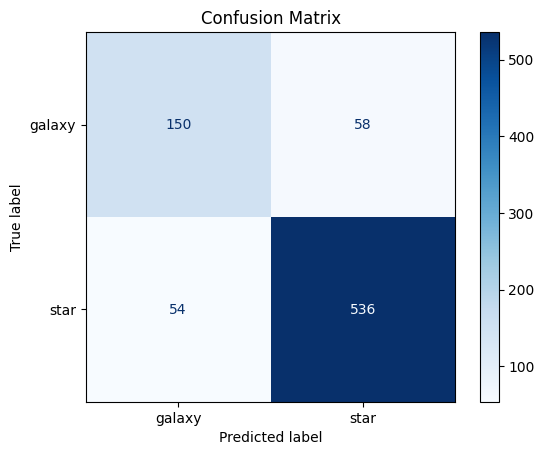

In [24]:
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

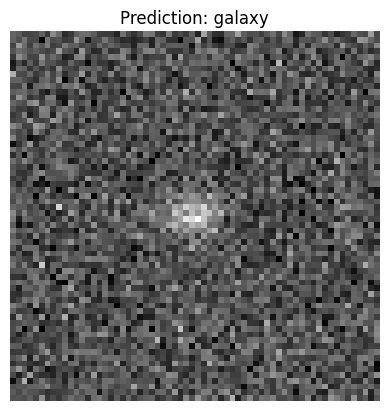

'galaxy'

In [35]:
from PIL import Image
import matplotlib.pyplot as plt

def predict_image(image_path, model, transform, class_names):
    model.eval()

    image = Image.open(image_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    with torch.no_grad():
        output = model(image_tensor)
        _, predicted = torch.max(output, 1)

    predicted_class = class_names[predicted.item()]

    plt.imshow(image)
    plt.title(f"Prediction: {predicted_class}")
    plt.axis('off')
    plt.show()

    return predicted_class

test_image_path = "/kaggle/input/dummy-astronomy-data/Cutout Files/galaxy/IC3521-H01_1361_946_3.jpg"
predict_image(test_image_path, model, transform, class_names)
